In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# Predicting the weight of ROUSes using Linear Regression
Using other data we have in the table, we want to predict the weight of ROUSes.

In [2]:
rouses = pd.read_csv('../data/ROUSes.csv')
print(rouses.shape)
rouses.head()

(29, 4)


,Age,Length,Weight,Temperament
0,9.5,4.1,93.2,Sleepy
1,12.0,4.1,97.7,Moody
2,14.5,4.6,120.3,No-nonsense
3,7.0,3.3,60.4,Moody
4,10.0,3.5,75.3,No-nonsense


# Exploratory analysis
First, let's look at some scatterplots of the numberic variables vs. weight.

<Axes: xlabel='Age', ylabel='Weight'>

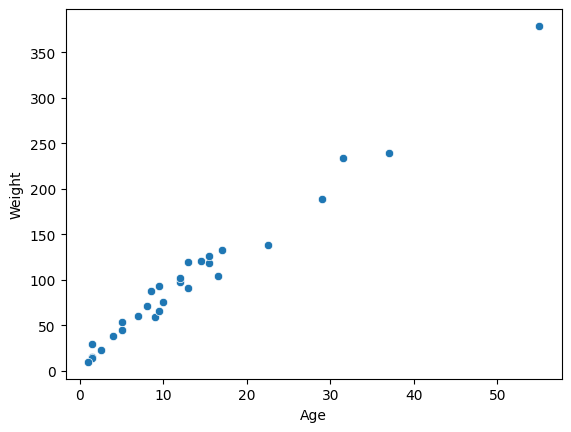

In [3]:
sns.scatterplot(data=rouses, x='Age',y='Weight')

<Axes: xlabel='Length', ylabel='Weight'>

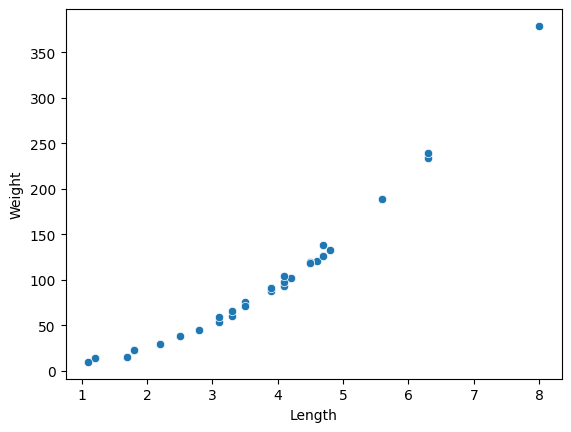

In [4]:
sns.scatterplot(data=rouses, x='Length',y='Weight')

In [5]:
rouses.corr(numeric_only=True)

,Age,Length,Weight
Age,1.000000,0.934265,0.988924
Length,0.934265,1.000000,0.959640
Weight,0.988924,0.959640,1.000000


`Age` seems to have a decently linear correlation with `Weight`.  `Length` looks more like a square relationship.  So we'll try using `Age` to predict `Weight`.  Let's drop the other columns.

In [6]:
rouses = rouses.drop(columns=['Temperament','Length']) # drop the column 'Name'
rouses.head()

,Age,Weight
0,9.5,93.2
1,12.0,97.7
2,14.5,120.3
3,7.0,60.4
4,10.0,75.3


Just as with Decision Trees, we will **randomly split the sample into two groups, and reserve the samples in the test set for evaluating the model**. 

Think of it as a professor reserving some questions in the question bank for the actual test (test) and releasing the rest as practice questions (train). Why would giving all the questions ahead of time be an inaccurate way to evaluate a student's understanding (model)?

In [7]:
train = rouses.sample(frac= 0.8) # 80% rows for training
test = rouses.drop(index=train.index) # rest of rows for testing
print(train.shape, test.shape)

(23, 2) (6, 2)


The next thing to do is to separate out the target data `Weight` from the predictor data (everything else; in this case just `Age` is left).

In [8]:
y_train = train['Weight']
X_train = train.drop(columns=['Weight'])
print(X_train.shape, y_train.shape)

y_test = test['Weight']
X_test = test.drop(columns=['Weight']) 
print(X_test.shape, y_test.shape)

(23, 1) (23,)
(6, 1) (6,)


## Training or fitting a model 

To use a machine learning model from `scikit-learn`, you should import the relevant model.

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('Train score:',lr.score(X_train, y_train))
print('Test score:',lr.score(X_test, y_test))

coefs = pd.DataFrame(lr.coef_, 
                     index=lr.feature_names_in_, 
                    columns=['Coefficient vals'])
coefs



Train score: 0.9813219164641175
Test score: 0.8891743573928665


,Coefficient vals
Age,6.587678


For linear regression a "score" (the R2 value) near 1 is what we are hoping for, and 0 is the worst result.  So our model is doing a very good job at predicting the data!  The coefficient tells us how much `Weight` change to expect with every unit change of `Age`.

To visualize our line, we can plug some values in and have their outputs predicted:

In [10]:
predict_inputs = pd.DataFrame({'Age':[1,55]})
predictions = lr.predict(predict_inputs)
predictions

array([ 19.98058915, 375.71518704])

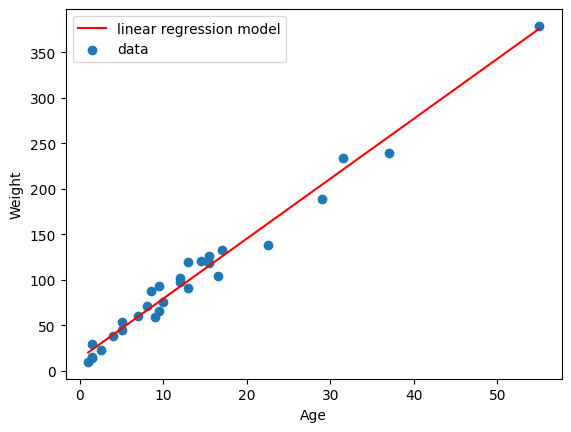

In [11]:
fig, ax = plt.subplots(1)

ax.plot([1,55], [predictions[0], predictions[1]], color = "red", label = "linear regression model")
ax.scatter(rouses['Age'], rouses['Weight'], label = "data")
ax.set(xlabel='Age', ylabel='Weight')
plt.legend()

Indeed, it looks like this line is a very good fit to our data!

## Multiple linear regression

Use both `Age` and `Length` to predict `Weight`.

In [12]:
rouses_full = pd.read_csv('../data/ROUSes.csv')
print(rouses_full.shape)
rouses_full.describe()

(29, 4)


,Age,Length,Weight
count,29.000000,29.000000,29.000000
mean,13.362069,3.841379,101.079310
std,12.042259,1.551386,79.294854
min,1.000000,1.100000,9.600000
25%,5.000000,3.100000,53.500000
50%,10.000000,3.900000,91.100000
75%,15.500000,4.600000,120.300000
max,55.000000,8.000000,378.900000


Note from the table above that `Age` and `Length` have different ranges/scales.
We'll see how that affects the final model and interpretation of coefficients.

In [13]:
def rouses_lr(rouses, seed=0):
    train = rouses.sample(frac=0.8, random_state=seed) # 80% rows for training
    test = rouses.drop(index=train.index) # rest of rows for testing
    
    y_train = train['Weight']
    X_train = train.drop(columns=['Weight'])
    
    y_test = test['Weight']
    X_test = test.drop(columns=['Weight']) 
    
    from sklearn.linear_model import LinearRegression
    
    lr = LinearRegression(fit_intercept=True)
    lr.fit(X_train, y_train)
    
    coefs = pd.DataFrame(lr.coef_, 
                         index=lr.feature_names_in_, 
                        columns=['Coefficient vals'])
    
    coefs.loc['Train score'] = lr.score(X_train, y_train)
    coefs.loc['Test score'] = lr.score(X_test, y_test)

    return coefs


In [14]:
rouses = rouses_full.filter(['Age', 'Weight', 'Length'])
seed = 100

#######
# This is called "whitening"
# make all features mean 0 and std 1
rouses_whitened = rouses - rouses.mean() # mean 0
rouses_whitened = rouses_whitened/rouses_whitened.std() # std = 1
#######

#######
# This is called "min-max scaling"
# make all values fall between 0 and 1
ranges = (rouses.max() - rouses.min()) # calculate the range
rouses_minmax = (rouses - rouses.min())/ranges 
#######

results = pd.DataFrame()
for df, name in zip([rouses, rouses_whitened, rouses_minmax], 
                    ["Unnormalized", "Whitened", "Min-max scaled"]):
    res = rouses_lr(df, seed)
    res = res.rename(columns ={'Coefficient vals': name})
    results = pd.concat((results, res), axis=1)
results

,Unnormalized,Whitened,Min-max scaled
Age,4.420154,0.671275,0.646326
Length,17.654315,0.345403,0.329853
Train score,0.987022,0.987022,0.987022
Test score,0.986728,0.986728,0.986728


In [15]:
rouses_minmax.describe()

,Age,Weight,Length
count,29.000000,29.000000,29.000000
mean,0.228927,0.247710,0.397301
std,0.223005,0.214717,0.224839
min,0.000000,0.000000,0.000000
25%,0.074074,0.118874,0.289855
50%,0.166667,0.220688,0.405797
75%,0.268519,0.299756,0.507246
max,1.000000,1.000000,1.000000


In [16]:
rouses_whitened.describe()

,Age,Weight,Length
count,2.900000e+01,2.900000e+01,2.900000e+01
mean,-2.201304e-17,-7.273875e-17,3.014830e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.026557e+00,-1.153660e+00,-1.767052e+00
25%,-6.943937e-01,-6.000302e-01,-4.778820e-01
50%,-2.791892e-01,-1.258507e-01,3.778602e-02
75%,1.775357e-01,2.423952e-01,4.889955e-01
max,3.457651e+00,3.503641e+00,2.680584e+00


# Another example
Here is another linear regression example for synthetically generated data that we actually know the **true** model

In [17]:
# controls random number generation
# always get the same data
np.random.seed(1234) 

# true model is linear with a = 1 and b = 1
a = 1
b = 1

n_points = 100

X = np.random.rand(n_points)
Y = a*X + b + 0.2*np.random.randn(n_points) # final term is random noise

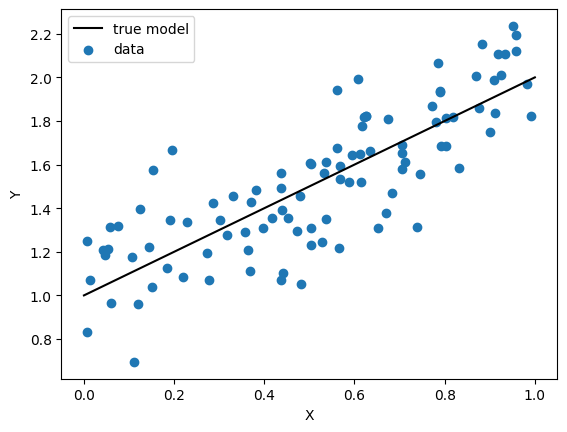

In [18]:
fig, ax = plt.subplots(1)

ax.plot([0,1], [1, 2], color = "black", label = "true model")
ax.scatter(X, Y, label = "data")
ax.set(xlabel='X', ylabel='Y')
plt.legend()

In [19]:
df = pd.DataFrame(data={'Y': Y, 'X': X})
train = df.sample(frac=0.8) # 80% rows for training
test = df.drop(index=train.index) # rest of rows for testing
print(train.shape, test.shape)
df


(80, 2) (20, 2)


,Y,X
0,1.344993,0.191519
1,1.819093,0.622109
2,1.491895,0.437728
3,2.063756,0.785359
4,1.795944,0.779976
...,...,...
95,1.233053,0.502560
96,1.609591,0.536878
97,1.816252,0.819202
98,1.311595,0.057116


In [20]:
y_train = train['Y']
X_train = train.drop(columns=['Y'])
print(X_train.shape, y_train.shape)

y_test = test['Y']
X_test = test.drop(columns=['Y']) 
print(X_test.shape, y_test.shape)

(80, 1) (80,)
(20, 1) (20,)


In [21]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)



LinearRegression()

In [22]:
lr.score(X_train, y_train) 
# R2 value for our training data 

0.6723254715066839

In [23]:
lr.score(X_test, y_test) 
# R2 value for our training data 

0.5889557948733519

In [24]:
coefs = pd.DataFrame(lr.coef_, 
                     index=lr.feature_names_in_, 
                    columns=['Coefficient vals'])
coefs

,Coefficient vals
X,0.991716


In [25]:
prediction_inputs = pd.DataFrame(data={'X': [0,1]})
predictions = lr.predict(prediction_inputs)
predictions

array([0.98687831, 1.9785944 ])

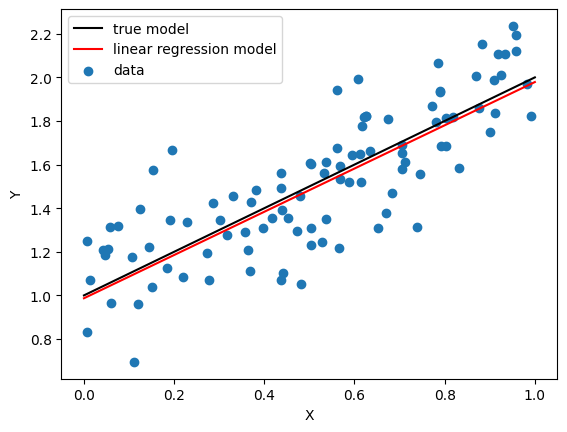

In [26]:
fig, ax = plt.subplots(1)

ax.plot([0,1], [1, 2], color = "black", label = "true model")
ax.plot([0,1], [predictions[0], predictions[1]], color = "red", label = "linear regression model")
ax.scatter(X, Y, label = "data")
ax.set(xlabel='X', ylabel='Y')
plt.legend()